# I. Packages Import

In [0]:
import pandas as pd
import numpy as np
import os
import json
import tempfile
import datetime

import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

Using TensorFlow backend.


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



# II. Data Loading

In [0]:
def read_csv(uploaded, name):
  from io import StringIO
  s=str(uploaded[name],'utf-8')
  data = StringIO(s) 
  df=pd.read_csv(data)
  return df

In [0]:
# Load reviews train dataset
link = "https://drive.google.com/open?id=16YyX6o1AUr1VNYB1DXnybxqqfA8Q-u1n"
_, drive_id = link.split('=')
downloaded = drive.CreateFile({'id': drive_id})
downloaded.GetContentFile('./sample_train.csv')
reviews_train = pd.read_csv('./sample_train.csv')
print(len(reviews_train))
reviews_train.head()

1088141


,user_id,business_id,rating,date,reviews,useful,funny,cool
0,jlu4CztcSxrKx56ba1a5AQ,3fw2X5bZYeW9xCz_zGhOHg,3.0,2016-05-07 01:21:02,Tracy dessert had a big name in Hong Kong and ...,5.0,4.0,5.0
1,5JVY32_bmTBfIGpCCsnAfw,Mem13A3C202RzT53npn4NA,5.0,2017-05-13 10:41:43,If you are looking for the best pierogies in P...,9.0,6.0,9.0
2,3CJUJILq7CLHk_9OrvpvQg,I4Nr-MVc26qWr08-S3Q1ow,4.0,2016-01-17 05:26:22,The food is always good and the prices are rea...,0.0,0.0,0.0
3,jAVtSgE5L-Dt6_I5FIiVGA,EIL41z-hvVCeYHqfA9PyWQ,5.0,2017-09-20 15:23:35,Flat out fantastic! Have been here twice and ...,1.0,0.0,1.0
4,XPZVfP7DQCSL3Nb9t2vxsA,1HD5iUUfVJDbfEBIn9yVhw,5.0,2017-03-15 02:02:13,Yes... the Boba Tea explosion is in full force...,11.0,8.0,11.0


In [0]:
# Load reviews test dataset
link = "https://drive.google.com/open?id=1P0p98XkIXW9QBVMDXFEiJMoaE8YsesWQ"
_, drive_id = link.split('=')
downloaded = drive.CreateFile({'id': drive_id})
downloaded.GetContentFile('./sample_test.csv')
reviews_test = pd.read_csv('./sample_test.csv')
print(len(reviews_test))
reviews_test.head()

63208


,user_id,business_id,rating,date,reviews,useful,funny,cool
0,IZPYIYdr05FvjKva2986aw,a0v7Si0DK4cIko7AQY4YXg,5.0,2018-04-27 18:31:23,Go. Seriously. You will not be disappointed on...,2,0,1
1,08Tj4NyfKvI9D-VMcQrwpw,0qSKZhVC_BHPuKro4QGWJw,5.0,2018-05-08 17:57:59,Hank's definitely stays on my list of places t...,0,0,0
2,4M25m7sE45Q_hNOch4b8fA,w8t3l-8xomzWDWhad4E_AQ,5.0,2018-05-28 20:27:57,Mr Cool Heating and Air Conditioning came to t...,2,0,0
3,co-GuD549dZTJ6OiJS1Ttw,KWywu2tTEPWmR9JnBc0WyQ,5.0,2017-02-19 09:17:53,It's awesome here!!The guys are soooo hot and ...,0,0,1
4,W1CQf1GKX0JZMWhT1jlTaA,PNbX4mT6krRy_I0il8Il4Q,5.0,2017-04-07 21:13:18,I was skeptical about all these great reviews....,0,0,0


In [0]:
# Load category dataset
link = "https://drive.google.com/open?id=1OnsZMo8ewo1wQdc9lQZ3aKF8h1Q2v-Q5"
_, drive_category = link.split('=')
downloaded = drive.CreateFile({'id': drive_category})
downloaded.GetContentFile('./bus_categories.csv')
category = pd.read_csv('./bus_categories.csv',index_col=0)
category = category.set_index('business_id')
print(len(category))
category.head()

158525


,Massage,Shoe Stores,Hakka,Private Investigation,Assisted Living Facilities,Chocolatiers & Shops,Gelato,Pedicabs,Life Insurance,Magicians,Used,Food Tours,Playsets,Brazilian,Bike tours,Hotel bar,Home Theatre Installation,Test Preparation,Criminal Defense Law,Drugstores,Home Energy Auditors,Medical Law,Paintball,Burmese,Singaporean,Holistic Animal Care,Real Estate Agents,Valet Services,Qi Gong,Laser Tag,Motorsport Vehicle Repairs,Tubing,Hindu Temples,Furniture Rental,Addiction Medicine,Grout Services,Nail Salons,Used Car Dealers,Russian,Pet Services,...,Speakeasies,Pet Adoption,Prosthodontists,Piano Services,Stadiums & Arenas,Flea Markets,Recording & Rehearsal Studios,Conveyor Belt Sushi,Jails & Prisons,Architects,Auto Repair,Bird Shops,Salvadoran,Unofficial Yelp Events,Car Auctions,Observatories,Hunting & Fishing Supplies,Smog Check Stations,Reptile Shops,Fencing Clubs,Auto Glass Services,Medical Supplies,Art Space Rentals,Mauritius,Misting System Services,Flooring,Process Servers,Tiling,Nurse Practitioner,American (New),Accessories,Float Spa,Cabaret,Excavation Services,Threading Services,Eyewear & Opticians,Home & Rental Insurance,Professional Services,University Housing,RV Rental
business_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
QXAEGFB4oINsVuTFxEYKFQ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
gnKjwL_1w79qoiV3IC_xQQ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
xvX2CttrVhyG2z1dFg_0xw,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
HhyxOkGAM07SRYtlQ4wMFQ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
68dUKd8_8liJ7in4aWOSEA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


- generate general category and special category

In [0]:
cate = category[category.index.isin(reviews_train['business_id'])]

In [0]:
count = pd.DataFrame(cate.sum(axis=0),columns = ['count'])
df = category.copy()
for i in df.columns:
  df[i] = df[i]*(count.loc[i,'count'])
cate_general = pd.DataFrame(df.idxmax(axis=1),columns = ['categories_general'])
cate_general.reset_index(inplace=True)

In [0]:
count = pd.DataFrame(cate.sum(axis=0),columns = ['count'])
drop = count[count['count']<=1000].index.tolist()
df = category.copy()
df.drop(columns = drop,inplace=True)
count = count[count['count']>1000]

mx = count.max()[0]+1
count['count'] = mx - count['count']
for i in df.columns:
  df[i] = df[i]*(count.loc[i,'count'])
cate_special = pd.DataFrame(df.idxmax(axis=1),columns = ['categories_special'])
cate_special.reset_index(inplace=True)
c = cate_general['categories_general'].unique()
cate_special.replace(list(c),'others',inplace=True)

In [0]:
# Load business dataset
link_biz = 'https://drive.google.com/open?id=1NyrsPerkXKKmu3woovR3hFob_o2FKAT6'
_, drive_id_biz = link_biz.split('=')
downloaded_biz = drive.CreateFile({'id': drive_id_biz})
downloaded_biz.GetContentFile('./business.json')
business = pd.read_json('./business.json', lines=True)
print(len(business))
business.head()

192609


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,1SWheh84yJXfytovILXOAQ,Arizona Biltmore Golf Club,2818 E Camino Acequia Drive,Phoenix,AZ,85016,33.522143,-112.018481,3.0,5,0,{'GoodForKids': 'False'},"Golf, Active Life",None
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,30 Eglinton Avenue W,Mississauga,ON,L5R 3E7,43.605499,-79.652289,2.5,128,1,"{'RestaurantsReservations': 'True', 'GoodForMe...","Specialty Food, Restaurants, Dim Sum, Imported...","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W..."
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0,170,1,"{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...","Sushi Bars, Restaurants, Japanese","{'Monday': '17:30-21:30', 'Wednesday': '17:30-..."
3,xvX2CttrVhyG2z1dFg_0xw,Farmers Insurance - Paul Lorenz,"15655 W Roosevelt St, Ste 237",Goodyear,AZ,85338,33.455613,-112.395596,5.0,3,1,None,"Insurance, Financial Services","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ..."
4,HhyxOkGAM07SRYtlQ4wMFQ,Queen City Plumbing,"4209 Stuart Andrew Blvd, Ste F",Charlotte,NC,28217,35.190012,-80.887223,4.0,4,1,"{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...","Plumbing, Shopping, Local Services, Home Servi...","{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ..."


In [0]:
# Load user dataset
link_user = "https://drive.google.com/open?id=1_HpHXyq41EODBjXGJOqmqN0vru9gF3UQ"
_, drive_id_user = link_user.split('=')
downloaded_user = drive.CreateFile({'id': drive_id_user})
downloaded_user.GetContentFile('./user.csv')
users = pd.read_csv('./user.csv')
print(len(users))
users.head()

63208


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,NQffx45eJaeqhFcMadKUQA,Trace,124,2008-12-10 22:59:45,202,70,185,NaN,"N-xeG3U6rUkjVtQ0o-5YZA, wnO99pBbGqwqOoTQM25iCw...",15,4.53,13,3,0,2,0,12,8,14,14,3,5
1,gvXtMj3XuPr0xHjgmlmtng,Peter,47,2014-01-05 20:45:54,57,26,34,"2017,2018","CfGCj80EdA-xS-mTWlAn4Q, JgD2Rk9K07MkZgG7Nb9YzA...",9,3.60,1,0,0,0,0,4,11,5,5,4,3
2,pU6GoRTcl1rIOi6zMynjog,Javier,470,2011-12-16 16:13:01,1655,1007,974,"2015,2016,2017,2018","tRC9YLo4LHquMVXZ9VO4Ag, -YpfTgz88rsPwsOvlfKn7w...",71,3.45,16,8,1,0,0,42,32,64,64,35,10
3,Ps_zkoSnuv2Gy-QIt0jEJg,Lea,127,2010-01-29 02:39:45,193,52,53,NaN,"c6VYt2qajpt-etcKrH93Jg, GIMg62Ga_YBstQUX_B1h2g...",5,4.05,2,1,0,1,0,0,6,1,1,1,3
4,t-nB38eHbeFuabXBdJMwvg,Katharine,412,2008-06-13 14:48:51,1816,463,1341,"2011,2012,2013,2014,2015,2016,2017,2018","2Y1pwMu2pZJDGQ7moD-2gQ, Qlys2g0R3PfNAuMOhagwLA...",77,4.02,106,3,4,1,1,60,64,140,140,120,65


# III. Data processing

In [0]:
# Define the column names for the data sets.
COLUMNS = ["user_id","business_id", "rating","state", "city",
           "item_stars", "item_count", "user_count", "user_stars","categories_general","categories_special"]
Y_COLUMN = 'rating'
CATEGORICAL_COLUMNS = ["categories_general","categories_special", "state", "city"]
CONTINUOUS_COLUMNS = ["item_stars", "item_count", "user_count", "user_stars"]

In [0]:
#define merge and select function
def merging(df,business,users,cate_general,cate_special,COLUMNS):
  temp = pd.merge(df, business, how='left', on='business_id')
  temp1 = pd.merge(temp, users, how='left', on='user_id')
  temp2 = pd.merge(temp1, cate_general, how='left', on='business_id')
  result = pd.merge(temp2, cate_special, how='left', on='business_id')
  result = result[["user_id","business_id","rating", "state", "city",
               "stars", "review_count_x", "review_count_y", "average_stars","categories_general","categories_special"]]
  
  result.columns = COLUMNS
  result['state'].fillna('none',inplace = True)
  return result

In [0]:
train = merging(reviews_train,business,users,cate_general,cate_special,COLUMNS)
test = merging(reviews_test,business,users,cate_general,cate_special,COLUMNS)

In [0]:
# clean city column
p = train.groupby('city').count()
d = p[p['user_id']>=50].index.tolist()
train.loc[~train['city'].isin(d),'city'] = 'other_cities'
test.loc[~test['city'].isin(d),'city'] = 'other_cities'

# IV. Model construction

In [0]:
# define function for tensorflow data format
def input_fn(df):
  # Creates a dictionary mapping from each continuous feature column name (k) to
  # the values of that column stored in a constant Tensor.
    continuous_cols = {k: tf.constant(df[k].values) for k in CONTINUOUS_COLUMNS}
  # Creates a dictionary mapping from each categorical feature column name (k)
  # to the values of that column stored in a tf.SparseTensor.
    categorical_cols = {k: tf.SparseTensor(indices=[[i, 0] for i in range(df[k].size)],
                                           values=df[k].values,
                                           dense_shape=[df[k].size, 1])
                        for k in CATEGORICAL_COLUMNS}
  # Merges the two dictionaries into one.
    feature_cols = dict(**continuous_cols, **categorical_cols)
  # Converts the label column into a constant Tensor.
    rate = tf.constant(df[Y_COLUMN].values)
    rating = tf.clip_by_value(rate, 0, 5)
  # Returns the feature columns and the label.
    return feature_cols, rating

def train_input_fn():
    return input_fn(df_train)

def eval_input_fn():
    return input_fn(df_test)

In [0]:
import tensorflow as tf

# Categorical base columns.
state = tf.contrib.layers.sparse_column_with_hash_bucket("state", hash_bucket_size=100)
city = tf.contrib.layers.sparse_column_with_hash_bucket("city", hash_bucket_size=1000)
categories_general = tf.contrib.layers.sparse_column_with_hash_bucket("categories_general", hash_bucket_size=1500)
categories_special = tf.contrib.layers.sparse_column_with_hash_bucket("categories_special", hash_bucket_size=1500)

# Continuous base columns.
item_stars = tf.contrib.layers.real_valued_column("item_stars")
item_count = tf.contrib.layers.real_valued_column("item_count")
user_count = tf.contrib.layers.real_valued_column("user_count")
user_stars = tf.contrib.layers.real_valued_column("user_stars")

item_buckets = tf.contrib.layers.bucketized_column(item_stars, boundaries=[1.0,2.0,3.0,4.0,5.0])
user_buckets = tf.contrib.layers.bucketized_column(user_stars, boundaries=[1.0,2.0,3.0,4.0,5.0])

In [0]:
wide_columns = [
  categories_general, categories_special, item_stars, item_count, user_count, user_stars, 
  tf.contrib.layers.crossed_column([item_buckets, user_buckets], hash_bucket_size=int(1e8)),
  tf.contrib.layers.crossed_column([categories_general, categories_special], hash_bucket_size=int(1e8))]

In [0]:
deep_columns = [
  tf.contrib.layers.embedding_column(categories_general, dimension=8),              
  tf.contrib.layers.embedding_column(categories_special, dimension=8),
  tf.contrib.layers.embedding_column(state, dimension=8),
  tf.contrib.layers.embedding_column(city, dimension=8),
  item_stars, item_count, user_count, user_stars]

# V. Model fitting

In [0]:
# define fitting function
def fit(lr=0.01,step=20):
  model_dir = tempfile.mkdtemp()
  m = tf.contrib.learn.DNNLinearCombinedRegressor(
      model_dir=model_dir,
      #wide
      linear_feature_columns=wide_columns,
      linear_optimizer=tf.compat.v1.train.FtrlOptimizer(
            learning_rate=lr),
      #deep
      dnn_feature_columns=deep_columns,
      dnn_optimizer=tf.compat.v1.train.ProximalAdagradOptimizer(learning_rate=lr),
      dnn_hidden_units=[10,5])
  m.fit(input_fn=train_input_fn, steps=step)
  return m

### Tunning hyper parameters

In [0]:
# randomly choose small dataset for validation
drop_set, use_set = train_test_split(train, test_size = 0.5, random_state=10)
train_set, valid_set = train_test_split(use_set, test_size = 0.2, random_state=10)

df_train = train_set
df_test = valid_set

In [0]:
# choose best learning rate
l_rmse = []
lmbda = [0.01,0.05,0.09,0.1,0.25,0.75]
for r in lmbda :
  m = fit(lr=r,step=100)
  results = m.evaluate(input_fn=eval_input_fn, steps=1)
  l_rmse.append(results['loss']**0.5) 

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fa3fccc10f0>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_eval_distribute': None, '_experimental_max_worker_delay_secs': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_protocol': None, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/tmp/tmpu6k5aqh4', '_session_creation_timeout_secs': 7200}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done run

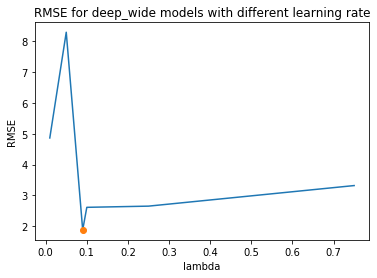

In [0]:
plt.plot(lmbda, l_rmse)
plt.xlabel('lambda')
plt.ylabel('RMSE')
plt.title('RMSE for deep_wide models with different learning rate')
plt.plot([lmbda[np.argmin(l_rmse)]], [min(l_rmse)], 'o')
plt.show()

In [0]:
# choose best number of training steps
n_rmse = []
n_iter = [50,100,125,150,175,200,250]
for n in n_iter :
  m = fit(lr=0.09,step=n)
  results = m.evaluate(input_fn=eval_input_fn, steps=1)
  n_rmse.append(results['loss']**0.5) 

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpex4mfnaa/model.ckpt-208
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 208 into /tmp/tmpex4mfnaa/model.ckpt.
INFO:tensorflow:loss = 2.8755832, step = 210
INFO:tensorflow:Saving checkpoints for 260 into /tmp/tmpex4mfnaa/model.ckpt.
INFO:tensorflow:Loss for final step: 2.3457136.
INFO:tensorflow:Starting evaluation at 2019-12-20T02:48:27Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpex4mfnaa/model.ckpt-260
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2019-12-20-02:48:31
INFO:tensorflow:Saving dict for global step 260: global_step = 260, loss = 2.3286507


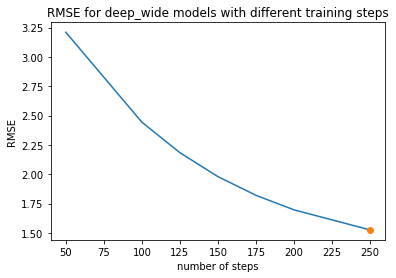

In [0]:
n_iter = [50,100,125,150,175,200,250]
plt.plot(n_iter, n_rmse)
plt.xlabel('number of steps')
plt.ylabel('RMSE')
plt.title('RMSE for deep_wide models with different training steps')
plt.plot([n_iter[np.argmin(n_rmse)]],[min(n_rmse)], 'o')
plt.show()

# VI. Evaluation

In [0]:
df_train = train
df_test = test

#### - RMSE

In [0]:
f = fit(lr=0.09,step=300)
results = f.evaluate(input_fn=eval_input_fn, steps=1)
for key in sorted(results):
    print("%s: %s" % (key, results[key]))

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpw_vec9s5/model.ckpt-282
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 282 into /tmp/tmpw_vec9s5/model.ckpt.
INFO:tensorflow:loss = 1.572588, step = 284
INFO:tensorflow:Saving checkpoints for 308 into /tmp/tmpw_vec9s5/model.ckpt.
INFO:tensorflow:Loss for final step: 1.5262767.
INFO:tensorflow:Starting evaluation at 2019-12-20T04:40:03Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpw_vec9s5/model.ckpt-308
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2019-12-20-04:40:06
INFO:tensorflow:Saving dict for global step 308: global_step = 308, loss = 1.8541682
global_step: 308
loss: 1.8541682


In [0]:
rmse = results['loss']**0.5
print('rmse: ', rmse)

rmse:  1.361678440987813


#### - MAE 

In [0]:
pre = f.predict(input_fn=eval_input_fn,as_iterable=False)
mae = np.sum(np.abs(pre - df_test['rating'].values))/len(pre)
print('mae: ', mae)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpw_vec9s5/model.ckpt-308
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
mae:  1.1856003479895116
